In [1]:
from fitsio import FITS
import fitsio
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np
import os
from matplotlib.pyplot import rcParams
import matplotlib._color_data as mcd
import math
rcParams['figure.figsize'] = 10, 5
rcParams['lines.linewidth'] = 2
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 12

import h5py
from scipy import interpolate
from picca import wedgize

In [2]:
def histo(x, cut=None, range=None, bins=50, alpha=1, clear=True, color='blue', xlab=None, text=None, datarange=None, grd=True, loc='best'):
        if cut is None:
                newx = x
        else:
                newx = x[cut]
        if xlab: plt.xlabel(xlab)
        lab = ' N: '+str(len(newx))+'\n mean: {0:.3g}'.format(np.mean(newx))+'\n rms: {0:.3g}'.format(np.std(newx))
        if text is not None: lab = text+'\n'+lab
        truc=plt.hist(newx, range=range, bins=bins, alpha=alpha, color=color, label=lab)
        plt.legend(loc=loc)
        if grd: plt.grid()
        return np.array([len(newx), np.mean(newx), np.std(newx)])
    

In [3]:
def get_result(L0,files):
    f_data = h5py.File(files[1],'r')
    list_data = list(f_data['best fit'].attrs.items())
    free_pars = []
    for array_data_1 in list_data:
        if array_data_1[0]=='list of free pars':
            for name in array_data_1[1][2:]:
                free_pars.append(name)
        if array_data_1[0]=='fval':
            free_pars.append(array_data_1[0])
        if array_data_1[0] == 'npar':
            free_pars.append(array_data_1[0])
        if array_data_1[0] == 'ndata':
            free_pars.append(array_data_1[0])
    free_pars = np.array(free_pars).reshape(-1)


    fval = []
    beta_LYA = []
    beta_LYA_error = []
    beta_hcd = []
    beta_hcd_error = []
    bias_eta_LYA = []
    bias_eta_LYA_error = []
    bias_hcd = []
    bias_hcd_error = []
    npars = []
    ndata = []
    for file in files:
        #print(file)
        f_data = h5py.File(file,'r')
        list_data = list(f_data['best fit'].attrs.items())
        for array_data in list_data:
            if array_data[0] in free_pars:
                if array_data[0] == 'fval':
                    fval.append(array_data[1])
                elif array_data[0] == 'beta_LYA':
                    beta_LYA.append(array_data[1][0])
                    beta_LYA_error.append(array_data[1][1])
                elif array_data[0] == 'beta_hcd':
                    beta_hcd.append(array_data[1][0])
                    beta_hcd_error.append(array_data[1][1])
                elif array_data[0] == 'bias_eta_LYA':
                    bias_eta_LYA.append(array_data[1][0])
                    bias_eta_LYA_error.append(array_data[1][1])
                elif array_data[0] == 'bias_hcd':
                    bias_hcd.append(array_data[1][0])
                    bias_hcd_error.append(array_data[1][1])
                elif array_data[0] == 'npar':
                    npars.append(array_data[1])
                elif array_data[0] == 'ndata':
                    ndata.append(array_data[1])
    L0_hcd = L0
    table = {'L0_hcd':np.array(L0_hcd),
             'X2':np.array(fval),
             'beta_LYA':np.array(beta_LYA),
    'beta_LYA_error':np.array(beta_LYA_error),
    'beta_hcd':np.array(beta_hcd),
    'beta_hcd_error':np.array(beta_hcd_error),
    'bias_eta_LYA':np.array(bias_eta_LYA),
    'bias_eta_LYA_error':np.array(bias_eta_LYA_error),
    'bias_hcd':np.array(bias_hcd),
    'bias_hcd_error':np.array(bias_hcd_error),
    'npars':np.array(npars),
    'ndata':np.array(ndata)}

    return table

In [4]:
import h5py
import scipy.stats as stats
import sys
def get_h5data(fname,dirname):
    f = h5py.File(dirname,'r')
    ap=f['best fit'].attrs['ap'][0]
    eap=f['best fit'].attrs['ap'][1]
    at=f['best fit'].attrs['at'][0]
    eat=f['best fit'].attrs['at'][1]
    biaseta=f['best fit'].attrs['bias_eta_LYA'][0]
    ebiaseta=f['best fit'].attrs['bias_eta_LYA'][1]
    beta=f['best fit'].attrs['beta_LYA'][0]
    ebeta=f['best fit'].attrs['beta_LYA'][1]
    chisq= f['best fit'].attrs['fval']
    ndata= f['best fit'].attrs['ndata']
    npar= f['best fit'].attrs['npar']
    pvalue = 1. - stats.chi2.cdf(chisq,ndata-npar)
    print (fname,'  & ',round(ap,3),round(eap,3),'  &  ',round(at,3),round(eat,3),' & ',round(biaseta,4),round(ebiaseta,4),'  &  ',round(beta,3),round(ebeta,3),'  &  ',round(chisq,2),'/(',ndata,'-',npar,')  p=',round(pvalue,3))

In [13]:
hdu=pyfits.open('/global/cfs/cdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.0/eboss-0.2/cf_z_0_10-exp.fits')
xi=hdu[1].data['DA']
exi=np.sqrt(np.diag(hdu[1].data['CO']))

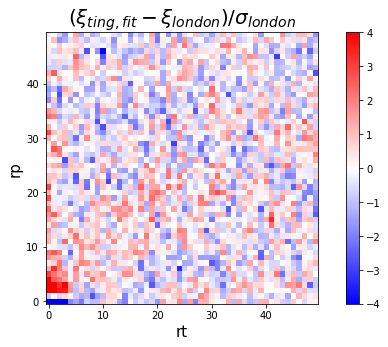

In [7]:
xi_ting = np.loadtxt('/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10.txt')
xi_london = np.loadtxt('/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10_london.txt')
cf_ting = ((xi_ting-xi)/exi).reshape(50,50)
cf_london = ((xi_london-xi)/exi).reshape(50,50)
fig = plt.figure() # create the canvas for plotting
plt.title(r'$(\xi_{ting,fit}-\xi_{london})/\sigma_{london}$', fontsize=20)
plt.imshow(cf_ting,vmax=4.,vmin=-4.,origin='lower',cmap='bwr')
plt.colorbar()
plt.xlabel('rt')
plt.ylabel('rp')
plt.show()

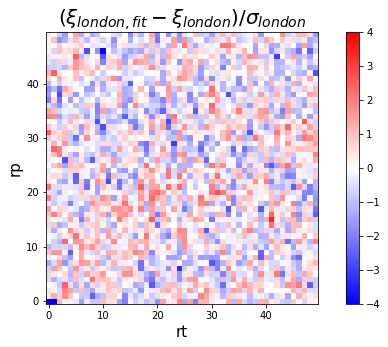

In [8]:
xi_ting = np.loadtxt('/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10.txt')
xi_london = np.loadtxt('/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10_london.txt')
cf_ting = ((xi_ting-xi)/exi).reshape(50,50)
cf_london = ((xi_london-xi)/exi).reshape(50,50)
fig = plt.figure() # create the canvas for plotting
plt.title(r'$(\xi_{london,fit}-\xi_{london})/\sigma_{london}$', fontsize=20)
plt.imshow(cf_london,vmax=4.,vmin=-4.,origin='lower',cmap='bwr')
plt.colorbar()
plt.xlabel('rt')
plt.ylabel('rp')
plt.show()

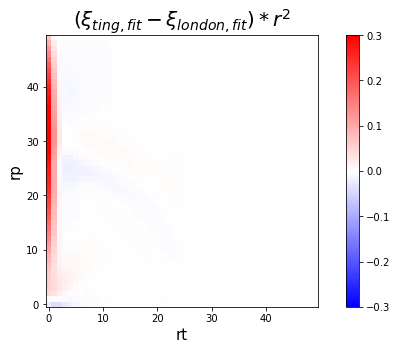

In [17]:
r_bins_square = hdu[1].data['RP']**2+hdu[1].data['RT']**2
xi_ting = np.loadtxt('/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10.txt')
xi_london = np.loadtxt('/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10_london.txt')
cf_difference = ((xi_ting-xi_london)*r_bins_square).reshape(50,50)
fig = plt.figure() # create the canvas for plotting
plt.title(r'$(\xi_{ting,fit}-\xi_{london,fit})*r^2$', fontsize=20)
plt.imshow(cf_difference,vmax=0.3,vmin=-0.3,origin='lower',cmap='bwr')
plt.colorbar()
plt.xlabel('rt')
plt.ylabel('rp')
plt.show()

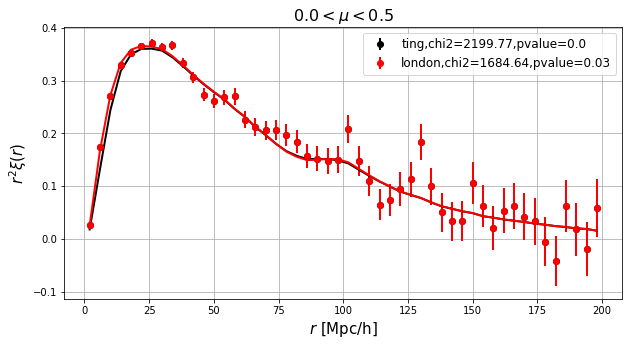

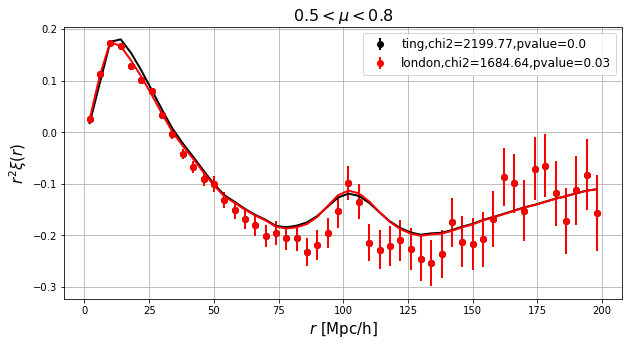

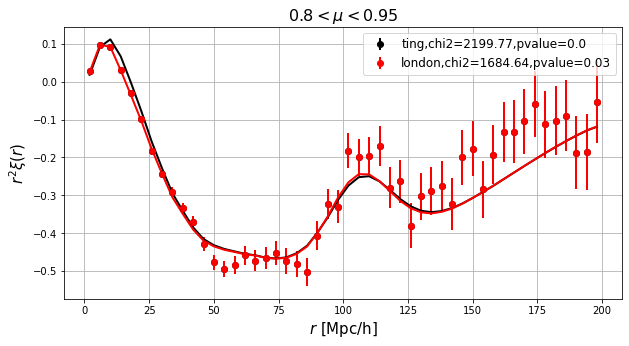

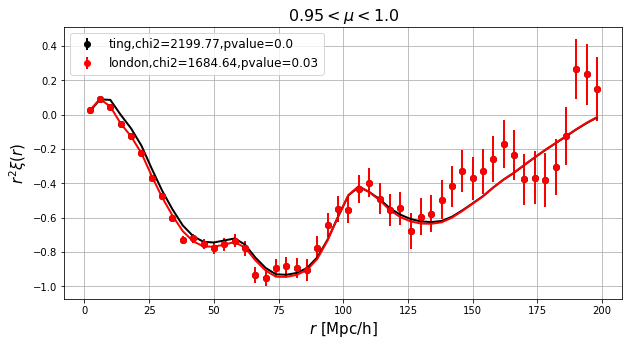

In [11]:
total_dir = '/global/cfs/cdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.0/eboss-0.2/'
names = ['ting',
         'london',]
paths_corr = [total_dir+'cf_z_0_10-exp.fits',
              total_dir+'cf_z_0_10-exp.fits',]
paths_txt = ['/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10.txt',
             '/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10_london.txt']
paths_fits = ['/global/cscratch1/sd/tanting/Result_hcd/London_1_100/Fits_mock_hcd_mask_200_rebins_3-0-100/result_rogers_L0_10.h5',
             '/global/cfs/cdirs/desi/science/lya/picca_on_mocks/london/v9.0/v9.0.0/eboss-0.2/cf_z_0_10-exp.h5']
mus=[0., 0.5, 0.8, 0.95, 1.]
#mus=[0.8, 0.95]
colors = ['black','red','blue','green','orange','violet','pink']
for mumin,mumax in zip(mus[:-1],mus[1:]):
    for i,name,path_corr,path_txt,path_fits,color in zip(range(3),names,paths_corr,paths_txt,paths_fits,colors):
        h = fitsio.FITS(path_corr)
        ff = h5py.File(path_fits,'r')
        fit = np.loadtxt(path_txt)
        da = h[1]['DA'][:]
        co = h[1]['CO'][:]
        chi2 = round(ff['best fit'].attrs['fval'],2)
        ndata= ff['best fit'].attrs['ndata']
        npar= ff['best fit'].attrs['npar']
        pvalue = round(1. - stats.chi2.cdf(chi2,ndata-npar),2)
        ff.close()
        rpmin = h[1].read_header()['RPMIN']
        NP = h[1].read_header()['NP']
        h.close()
        b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=NP,absoluteMu=True)
        if name == '10 mock wHCD r200 reb 2 binsize 2':
            b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=100,nrt=100,nr=100,absoluteMu=True)
        elif name == '10 mock wHCD r100 reb 2 binsize 2':
            b = wedgize.wedge(mumin=mumin,mumax=mumax,rpmax=100,rtmax=100,rmax=100,absoluteMu=True)
        r,d,c = b.wedge(da,co)
        r,f,_ = b.wedge(fit,co)
        #plt.errorbar((r/2),d*(r/2)**2,yerr=c.diagonal()**0.5*r**2,fmt="o",label=r'$\mathrm{'+name+'}$')
        #plt.plot(r/2,f*(r/2)**2)
        plt.errorbar((r),d*(r)**2,yerr=c.diagonal()**0.5*r**2,fmt="o",label='{},chi2={},pvalue={}'.format(name,chi2,pvalue),color = color)
        plt.plot(r,f*(r)**2,color = color)
    
    plt.ylabel(r"$r^2\xi(r)$")
    plt.xlabel(r"$r~[\mathrm{Mpc/h}]$")
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()